In [1]:
import numpy as np
from scipy import special
from scipy.stats import multivariate_normal
import pickle
from scipy import integrate

## Defining Gaussian model

In [2]:
alpha_star=special.erfinv(0.98)*np.sqrt(2)

In [3]:
alpha_star

2.3263478740408408

### Parameters

In [52]:
d=100
evalues=np.random.default_rng().uniform(0,1,d)

sigma = np.diag(evalues)
sigma_inv = np.linalg.inv(sigma)

mu=(alpha_star)*np.sqrt(evalues)/np.sqrt(d)

np.dot(mu,np.dot(sigma_inv,mu))

5.411894431054339

In [53]:
mean_dist=np.linalg.norm(2*mu)
mean_dist

3.1771360731991427

### Optimal classifier

In [54]:
delta_init = np.linspace(0,3,10)
rhs_vec=mu
w_opt=[]
eps_opt=[]
for delta in delta_init:
    lhs_mat = 0.5*(sigma+2*delta*np.eye(d))
    w=np.linalg.solve(lhs_mat,rhs_vec)
    eps_curr=delta*np.linalg.norm(w)
    print('Optimal for eps %s' % eps_curr)
    w_opt.append(w)
    eps_opt.append(eps_curr)

Optimal for eps 0.0
Optimal for eps 0.8717147883215444
Optimal for eps 1.1091007463449618
Optimal for eps 1.2272388453408194
Optimal for eps 1.2984103665791054
Optimal for eps 1.3460730970343333
Optimal for eps 1.3802517369743132
Optimal for eps 1.405969593593899
Optimal for eps 1.426026717340934
Optimal for eps 1.4421088973359129


In [55]:
optimal_losses = []
for i in range(len(delta_init)):
#     alpha = np.sqrt((np.dot(w_opt[i],mu)-eps_opt[i]*np.linalg.norm(w_opt[i]))/2)
    alpha = (-eps_opt[i]*np.linalg.norm(w_opt[i])+np.dot(w_opt[i],mu))/np.sqrt(np.dot(w_opt[i],np.dot(sigma,w_opt[i])))
    Q_alpha = 0.5 - 0.5*special.erf(alpha/np.sqrt(2))
    optimal_loss=Q_alpha
    optimal_losses.append(optimal_loss)
    print('Optimal loss at %s is %s' % (eps_opt[i],optimal_loss))

Optimal loss at 0.0 is 0.010000000000000009
Optimal loss at 0.8717147883215444 is 0.1722448707581814
Optimal loss at 1.1091007463449618 is 0.2666695861914837
Optimal loss at 1.2272388453408194 is 0.32048749061152215
Optimal loss at 1.2984103665791054 is 0.35454749226191445
Optimal loss at 1.3460730970343333 is 0.3778893087156767
Optimal loss at 1.3802517369743132 is 0.3948370630972617
Optimal loss at 1.405969593593899 is 0.40768352049904144
Optimal loss at 1.426026717340934 is 0.4177488185590096
Optimal loss at 1.4421088973359129 is 0.42584403687620054


## Gaussian pdf

In [44]:
log_losses=[]
for i in range(len(w_opt)):
    w=w_opt[i]
    z=eps_opt[i]*(w_opt[i]/(np.linalg.norm(w_opt[i])))
    y_bar_pos=2.0*np.dot(np.dot(mu-z,sigma_inv),mu-z)
    scale_factor_pos=4.0*np.dot(np.dot(mu-z,sigma_inv),mu-z)
    y_bar_neg=2.0*np.dot(np.dot(mu+z,sigma_inv),mu+z)
    scale_factor_neg=4.0*np.dot(np.dot(mu+z,sigma_inv),mu+z)
    def f_pos(x):
        f_1=np.log(1+np.exp(-1.0*np.sqrt(scale_factor_pos)*x-1.0*y_bar_pos))
        f_2=(1/np.sqrt(2.0*np.pi))*np.exp((-1*(x)**2)/(2.0))
        return f_1*f_2
    def f_neg(x):
        f_1=np.log(1+np.exp(-1.0*np.sqrt(scale_factor_neg)*x-1.0*y_bar_neg))
        f_2=(1/np.sqrt(2.0*np.pi))*np.exp((-1*(x)**2)/(2.0))
        return f_1*f_2
    loss=integrate.quad(f_pos,-10,10)[0]
#     +0.5*integrate.quad(f_neg,-10,10)[0]
    log_losses.append(loss)

In [45]:
log_losses

[0.02735395181796572,
 0.35066128105142813,
 0.5039892719452963,
 0.5760379851607923,
 0.6142293512509142,
 0.6365989970075017,
 0.6507341774366574,
 0.660201392651782,
 0.666838357568481,
 0.6716646368912544]

### Optimal log loss computation

In [4]:
import scipy.spatial.distance
import time

from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.csgraph import maximum_flow
from utils.flow import _make_edge_pointers
import queue

In [5]:
def find_remaining_cap_edges(edge_ptr,capacities,heads,tails, source, sink):
    ITYPE = np.int32
    n_verts = edge_ptr.shape[0] - 1
    n_edges = capacities.shape[0]
    ITYPE_MAX = np.iinfo(ITYPE).max

    # Our result array will keep track of the flow along each edge
    flow = np.zeros(n_edges, dtype=ITYPE)

    # Create a circular queue for breadth-first search. Elements are
    # popped dequeued at index start and queued at index end.
    q = np.empty(n_verts, dtype=ITYPE)

    # Create an array indexing predecessor edges
    pred_edge = np.empty(n_verts, dtype=ITYPE)

    # While augmenting paths from source to sink exist
    for k in range(n_verts):
        pred_edge[k] = -1
    path_edges = []
    # Reset queue to consist only of source
    q[0] = source
    start = 0
    end = 1
    # While we have not found a path, and queue is not empty
    path_found = False
    while start != end and not path_found:
        # Pop queue
        cur = q[start]
        start += 1
        if start == n_verts:
            start = 0
        # Loop over all edges from the current vertex
        for e in range(edge_ptr[cur], edge_ptr[cur + 1]):
            t = heads[e]
            if pred_edge[t] == -1 and t != source and\
                    capacities[e] > flow[e]:
                pred_edge[t] = e
                path_edges.append((cur,t))
                if t == sink:
                    path_found = True
                    break
                # Push to queue
                q[end] = t
                end += 1
                if end == n_verts:
                    end = 0
    return path_edges

def create_graph_rep(edge_matrix,n_1,n_2):
    graph_rep = []
    for i in range(n_1+n_2+2):
        graph_rep.append([])
        if i==0:
            #source
            for j in range(n_1+n_2+2):
                if j==0:
                    graph_rep[i].append(0)
                elif 1<=j<=n_1:
                    graph_rep[i].append(n_2)
                elif n_1<j<=n_1+n_2+1:
                    graph_rep[i].append(0)
        elif 1<=i<=n_1:
            # LHS vertices
            for j in range(n_1+n_2+2):
                if j<=n_1:
                    graph_rep[i].append(0)
                elif n_1<j<=n_1+n_2:
                    if edge_matrix[i-1,j-n_1-1]:
                        graph_rep[i].append(n_1*n_2)
                    else:
                        graph_rep[i].append(0)
                elif n_1+n_2<j:
                    graph_rep[i].append(0)
        elif n_1<i<=n_1+n_2:
            #RHS vertices
            for j in range(n_1+n_2+2):
                if j<=n_1+n_2:
                    graph_rep[i].append(0)
                elif j>n_1+n_2:
                    graph_rep[i].append(n_1)
        elif i==n_1+n_2+1:
            #Sink
            for j in range(n_1+n_2+2):
                graph_rep[i].append(0)

    graph_rep_array=np.array(graph_rep)

    return graph_rep_array

def set_classifier_prob_full_flow(top_level_vertices,n_1_curr,n_2_curr,sink_idx,classifier_probs):
    for item in top_level_vertices:
        if item !=0 and item != sink_idx:
            classifier_probs[item-1,0]=n_1_curr/(n_1_curr+n_2_curr)
            classifier_probs[item-1,1]=n_2_curr/(n_1_curr+n_2_curr)

def set_classifier_prob_no_flow(top_level_vertices,sink_idx,n_1,classifier_probs):
    for item in top_level_vertices:
        if item !=0 and item != sink_idx:
            if item<=n_1:
                classifier_probs[item-1,0]=1
                classifier_probs[item-1,1]=0
            elif item>n_1:
                classifier_probs[item-1,0]=0
                classifier_probs[item-1,1]=1

def graph_rescale(graph_rep_curr,top_level_indices,n_1,n_2):
    n_1_curr=len(np.where(top_level_indices<=n_1)[0])-1
    n_2_curr=len(np.where(top_level_indices>n_1)[0])-1
    # source rescale
    # print(graph_rep_curr[0])
    graph_rep_curr[0,:]=graph_rep_curr[0,:]/n_2
    graph_rep_curr[0,:]*=n_2_curr
    # print(graph_rep_curr[0])
    # bipartite graph edge scale
    graph_rep_curr[1:n_1_curr+1,:]=graph_rep_curr[1:n_1_curr+1,:]/(n_1*n_2)
    graph_rep_curr[1:n_1_curr+1,:]*=(n_1_curr*n_2_curr)
    # sink edges rescale
    graph_rep_curr[n_1_curr+1:,:]=graph_rep_curr[n_1_curr+1:,:]/n_1
    graph_rep_curr[n_1_curr+1:,:]*=n_1_curr
    return graph_rep_curr,n_1_curr,n_2_curr

In [6]:
def find_flow_and_split(top_level_indices,graph_rep_array,n_1,n_2,classifier_probs):
    sink_idx=n_1+n_2+1
    top_level_indices_1=None
    top_level_indices_2=None
    #Create subgraph from index array provided
    graph_rep_curr = graph_rep_array[top_level_indices]
    graph_rep_curr = graph_rep_curr[:,top_level_indices]
    graph_rep_curr,n_1_curr,n_2_curr = graph_rescale(graph_rep_curr,top_level_indices,n_1,n_2)
    graph_curr=csr_matrix(graph_rep_curr)
    flow_curr = maximum_flow(graph_curr,0,len(top_level_indices)-1)
    # Checking if full flow occurred, so no need to split
    if flow_curr.flow_value==n_1_curr*n_2_curr:
        set_classifier_prob_full_flow(top_level_indices,n_1_curr,n_2_curr, sink_idx,classifier_probs)
        return top_level_indices_1,top_level_indices_2, flow_curr
    elif flow_curr.flow_value==0:
        set_classifier_prob_no_flow(top_level_indices,sink_idx,n_1,classifier_probs)
        return top_level_indices_1,top_level_indices_2, flow_curr
    # Finding remaining capacity edges
    remainder_array = graph_curr-flow_curr.residual

    rev_edge_ptr, tails = _make_edge_pointers(remainder_array)

    edge_ptr=remainder_array.indptr
    capacities=remainder_array.data
    heads=remainder_array.indices

    edge_list_curr = find_remaining_cap_edges(edge_ptr,capacities,heads,tails,0,len(top_level_indices)-1)

#     print(edge_list_curr)
    gz_idx = []
    for item in edge_list_curr:
        gz_idx.append(item[0])
        gz_idx.append(item[1])
    if len(gz_idx)>0:
        gz_idx=np.array(gz_idx)
        gz_idx_unique=np.unique(gz_idx)
        top_level_gz_idx=top_level_indices[gz_idx_unique]
        top_level_gz_idx=np.insert(top_level_gz_idx,len(top_level_gz_idx),sink_idx)
        top_level_indices_1=top_level_gz_idx
    else:
        top_level_gz_idx=np.array([0,sink_idx])
    # Indices without flow
    top_level_z_idx=np.setdiff1d(top_level_indices,top_level_gz_idx)
    if len(top_level_z_idx)>0:
        # Add source and sink back to zero flow idx array
        top_level_z_idx=np.insert(top_level_z_idx,0,0)
        top_level_z_idx=np.insert(top_level_z_idx,len(top_level_z_idx),sink_idx)
        top_level_indices_2=top_level_z_idx
    
    return top_level_indices_1,top_level_indices_2, flow_curr

In [7]:
def log_empirical_cost(X_1,X_2,eps):
    D_12 = scipy.spatial.distance.cdist(X_1,X_2,metric='euclidean')
    edge_matrix = D_12 <= 2*eps
    edge_matrix = edge_matrix.astype(float)

    num_edges = len(np.where(edge_matrix!=0)[0])
    # num_edges_list.append(num_edges)

    n_1=len(X_1)
    n_2=len(X_2)
    print(n_1,n_2)

    # Create graph representation
    graph_rep_array = create_graph_rep(edge_matrix,n_1,n_2)

    time1= time.clock()
    q = queue.Queue()
    # Initial graph indices
    q.put(np.arange(n_1+n_2+2))
    sink_idx=n_1+n_2+1
    count=0
    classifier_probs=np.zeros((n_1+n_2,2))
    while not q.empty():
        print('Current queue size at eps %s is %s' % (eps,q.qsize()))
        curr_idx_list=q.get()
        # print(q.qsize())
        list_1, list_2, flow_curr=find_flow_and_split(curr_idx_list,graph_rep_array,n_1,n_2,classifier_probs)
        # print(list_1,list_2,flow_curr.flow_value)
        if list_1 is not None:
            q.put(list_1)
        if list_2 is not None:
            q.put(list_2)
    time2 = time.clock()
    
    loss = 0.0
    for i in range(len(classifier_probs)):
        if i<n_1:
            loss+=np.log(classifier_probs[i][0])
        elif i>=n_1:
            loss+=np.log(classifier_probs[i][1])
    loss=-1*loss/len(classifier_probs)
    
    return classifier_probs, loss

In [ ]:
loss = 0.0
for i in range(len(classifier_probs)):
    if i<n_1:
        loss+=np.log(classifier_probs[i][0])
    elif i>=n_1:
        loss+=np.log(classifier_probs[i][1])
loss=-1*loss/len(classifier_probs)
print('Log loss for eps %s is %s' % (eps,loss))

### Loop

In [8]:
rng = np.random.default_rng(77)
d_list = [2,10,100]
# d_list=[10]
param_list = []
sample_list = []
sample_list_test = []
emp_log_loss_list = []
eps_opt_list = []
optimal_loss_list = []
w_opt_list=[]
for i,d in enumerate(d_list):
    print(i,d)
    # Gaussian params
    evalues=np.random.default_rng().uniform(0,1,d)
    sigma = np.diag(evalues)
    sigma_inv = np.linalg.inv(sigma)
    mu=(alpha_star)*np.sqrt(evalues)/np.sqrt(d)
    param_list.append([mu,evalues])
    # Run eps search
    delta_init = np.linspace(0,3,10)
#     delta_init=np.linspace(0,10,1)
    rhs_vec=mu
    w_opt=[]
    eps_opt=[]
    for delta in delta_init:
        lhs_mat = 0.5*(sigma+2*delta*np.eye(d))
        w=np.linalg.solve(lhs_mat,rhs_vec)
        eps_curr=delta*np.linalg.norm(w)
        #print('Optimal for eps %s' % eps_curr)
        w_opt.append(w)
        eps_opt.append(eps_curr)
    eps_opt_list.append(eps_opt)
    w_opt_list.append(w_opt)
    # Compute optimal loss
    optimal_losses = []
    for i in range(len(delta_init)):
#         alpha = np.sqrt((np.dot(w_opt[i],mu)-eps_opt[i]*np.linalg.norm(w_opt[i]))/2)
        alpha = (-eps_opt[i]*np.linalg.norm(w_opt[i])+np.dot(w_opt[i],mu))/np.sqrt(np.dot(w_opt[i],np.dot(sigma,w_opt[i])))
        Q_alpha = 0.5 - 0.5*special.erf(alpha/np.sqrt(2))
        optimal_loss=Q_alpha
        optimal_losses.append(optimal_loss)
        #print('Optimal loss at %s is %s' % (eps_opt[i],optimal_loss))
    optimal_loss_list.append(optimal_losses)
    # Generate samples
#     sample_num_list = [500]
    sample_num_list = [1000,5000]
    samples=[]
    emp_loss=[]
    for j, num_samples in enumerate(sample_num_list):
        print(j,num_samples)
        X_1 = rng.multivariate_normal(-1.0*mu, sigma, (num_samples))
        X_2 = rng.multivariate_normal(mu, sigma, (num_samples))
        X=np.vstack((X_1,X_2))
        samples.append(X)
        emp_loss_per_sample=[]
        for eps in eps_opt:
            classifier_probs, log_loss_min = log_empirical_cost(X_1,X_2,eps)
            emp_loss_per_sample.append(log_loss_min)
        emp_loss.append(emp_loss_per_sample)
    emp_log_loss_list.append(emp_loss)
    sample_list.append(samples)
    # Generate test samples
    num_samples_test=1000
    X_1_test = rng.multivariate_normal(-1.0*mu, sigma, (num_samples_test))
    X_2_test = rng.multivariate_normal(mu, sigma, (num_samples_test))
    X_test=np.vstack((X_1_test,X_2_test))
    sample_list_test.append(X_test)
    print(optimal_losses)
    print(emp_loss)
PIK1 = "gauss_sample.dat"
with open(PIK1, "wb") as f:
    pickle.dump(sample_list, f)
PIK2 = "gauss_params.dat"
with open(PIK2, "wb") as f:
    pickle.dump(param_list, f)
PIK3 = "eps_opt.dat"
with open(PIK3, "wb") as f:
    pickle.dump(eps_opt_list, f)
PIK4 = "opt_01_losses.dat"
with open(PIK4, "wb") as f:
    pickle.dump(optimal_loss_list, f)
PIK5 = "emp_log_losses.dat"
with open(PIK5, "wb") as f:
    pickle.dump(emp_log_loss_list, f)
PIK6 = "opt_w.dat"
with open(PIK6, "wb") as f:
    pickle.dump(w_opt_list, f)
PIK7 = "gauss_sample_test.dat"
with open(PIK7, "wb") as f:
    pickle.dump(sample_list_test, f)

0 2
0 1000
1000 1000
Current queue size at eps 0.0 is 1
1000 1000
Current queue size at eps 0.9430351125069351 is 1
Current queue size at eps 0.9430351125069351 is 2
Current queue size at eps 0.9430351125069351 is 3
Current queue size at eps 0.9430351125069351 is 4
Current queue size at eps 0.9430351125069351 is 5
Current queue size at eps 0.9430351125069351 is 6
Current queue size at eps 0.9430351125069351 is 7
Current queue size at eps 0.9430351125069351 is 8
Current queue size at eps 0.9430351125069351 is 9
Current queue size at eps 0.9430351125069351 is 10
Current queue size at eps 0.9430351125069351 is 11
Current queue size at eps 0.9430351125069351 is 12
Current queue size at eps 0.9430351125069351 is 13
Current queue size at eps 0.9430351125069351 is 14
Current queue size at eps 0.9430351125069351 is 15
Current queue size at eps 0.9430351125069351 is 16
Current queue size at eps 0.9430351125069351 is 15
Current queue size at eps 0.9430351125069351 is 16
Current queue size at eps

### Load all stored parameters

In [8]:
PIK1 = "gauss_sample.dat"
with open(PIK1, "rb") as f:
    sample_list=pickle.load(f)
PIK2 = "gauss_params.dat"
with open(PIK2, "rb") as f:
    param_list=pickle.load(f)
PIK3 = "eps_opt.dat"
with open(PIK3, "rb") as f:
    eps_opt_list=pickle.load(f)
PIK4 = "opt_01_losses.dat"
with open(PIK4, "rb") as f:
    optimal_loss_list=pickle.load(f)
PIK5 = "emp_log_losses.dat"
with open(PIK5, "rb") as f:
    emp_log_loss_list=pickle.load(f)
PIK6 = "opt_w.dat"
with open(PIK6, "rb") as f:
    w_opt_list=pickle.load(f)
PIK7 = "gauss_sample_test.dat"
with open(PIK7, "rb") as f:
    sample_test_list=pickle.load(f)

In [18]:
eps_list

array([1.5       , 1.83333333, 2.16666667, 2.5       , 2.83333333,
       3.16666667, 3.5       , 3.83333333, 4.16666667, 4.5       ])

In [16]:
d_list = [2,10,100]
sample_num_list = [1000,5000]
eps_list=np.linspace(1.5,4.5,10)
high_eps_loss_list=[]
for i,d in enumerate(d_list):
    if d!=100:
        continue
    else:
        samples=[]
        emp_loss=[]
        for j, num_samples in enumerate(sample_num_list):
            print(d,num_samples)
            high_eps_loss_list.append([])
            samples=sample_list[i][j]
            X_1=samples[:num_samples]
            X_2=samples[num_samples:]
            emp_loss_per_sample=[]
            for eps in eps_list:
                classifier_probs, log_loss_min = log_empirical_cost(X_1,X_2,eps)
                print(log_loss_min)
                high_eps_loss_list[j].append(log_loss_min)

100 1000
1000 1000
Current queue size at eps 1.5 is 1
-0.0
1000 1000
Current queue size at eps 1.8333333333333333 is 1
-0.0
1000 1000
Current queue size at eps 2.1666666666666665 is 1
-0.0
1000 1000
Current queue size at eps 2.5 is 1
-0.0
1000 1000
Current queue size at eps 2.833333333333333 is 1
-0.0
1000 1000
Current queue size at eps 3.1666666666666665 is 1
Current queue size at eps 3.1666666666666665 is 2
Current queue size at eps 3.1666666666666665 is 1
Current queue size at eps 3.1666666666666665 is 2
Current queue size at eps 3.1666666666666665 is 1
0.0020794415416798355
1000 1000
Current queue size at eps 3.5 is 1
Current queue size at eps 3.5 is 2
Current queue size at eps 3.5 is 3
Current queue size at eps 3.5 is 4
Current queue size at eps 3.5 is 3
Current queue size at eps 3.5 is 4
Current queue size at eps 3.5 is 5
Current queue size at eps 3.5 is 4
Current queue size at eps 3.5 is 5
Current queue size at eps 3.5 is 6
Current queue size at eps 3.5 is 5
Current queue size a

In [17]:
high_eps_loss_list

[[-0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  0.0020794415416798355,
  0.07458030915117685,
  0.41280418729043544,
  0.6686875096705233,
  0.6928004817818646],
 [-0.0,
  -0.0,
  -0.0,
  -0.0,
  0.00013862943611198905,
  0.00934770795376438,
  0.18080395755275874,
  0.5692913239323514,
  0.6884517998001194,
  0.6930778608413644]]

In [10]:
d_list = [2,10,100]
optimal_log_loss_list=[]
for i,d in enumerate(d_list):
    optimal_log_loss=[]
    print(i,d)
    w_opt=w_opt_list[i]
    eps_opt=eps_opt_list[i]
    mu=param_list[i][0]
    sigma = np.diag(param_list[i][1])
    sigma_inv = np.linalg.inv(sigma)
    # Gaussian params
    for j in range(len(w_opt)):
        w=w_opt[j]
        z=eps_opt[j]*(w_opt[j]/(np.linalg.norm(w_opt[j])))
        y_bar_pos=2.0*np.dot(np.dot(mu-z,sigma_inv),mu-z)
        scale_factor_pos=4.0*np.dot(np.dot(mu-z,sigma_inv),mu-z)
#         y_bar_neg=2.0*np.dot(np.dot(mu+z,sigma_inv),mu+z)
#         scale_factor_neg=4.0*np.dot(np.dot(mu+z,sigma_inv),mu+z)
        def f_pos(x):
            f_1=np.log(1+np.exp(-1.0*np.sqrt(scale_factor_pos)*x-1.0*y_bar_pos))
            f_2=(1/np.sqrt(2.0*np.pi))*np.exp((-1*(x)**2)/(2.0))
            return f_1*f_2
        def f_neg(x):
            f_1=np.log(1+np.exp(-1.0*np.sqrt(scale_factor_neg)*x-1.0*y_bar_neg))
            f_2=(1/np.sqrt(2.0*np.pi))*np.exp((-1*(x)**2)/(2.0))
            return f_1*f_2
        loss=integrate.quad(f_pos,-10,10)[0]
    #     +0.5*integrate.quad(f_neg,-10,10)[0]
        optimal_log_loss.append(loss)
    optimal_log_loss_list.append(optimal_log_loss)

0 2
1 10
2 100


In [49]:
optimal_log_loss_list

[[0.02735395181796572,
  0.34491639523934803,
  0.5142907080023629,
  0.5879896718209835,
  0.6247270698454196,
  0.6453204850392801,
  0.6579233072384246,
  0.666163245805979,
  0.6718328918059584,
  0.6758949195686956],
 [0.02735395181796572,
  0.3509940653880574,
  0.5019097753817559,
  0.5739178951503482,
  0.6124528478756097,
  0.6351600986326852,
  0.6495670989282534,
  0.6592444113832178,
  0.6660433397922724,
  0.6709956323402867],
 [0.02735395181796572,
  0.40606415094051634,
  0.544961599886103,
  0.604282761510223,
  0.6343219087870953,
  0.6514627755112086,
  0.6621156915526444,
  0.6691703322951588,
  0.6740759284367419,
  0.6776215761232787]]

In [15]:
eps_opt_list

[[0.0,
  0.9430351125069351,
  1.2096545454888337,
  1.3355198734131313,
  1.408815168422549,
  1.4567860238291532,
  1.4906239358392066,
  1.515772676938604,
  1.5351983365263246,
  1.5506549330263055],
 [0.0,
  0.8629747219650739,
  1.1238378607669903,
  1.2594703348739251,
  1.3429278059340677,
  1.3995232801244584,
  1.4404465056905755,
  1.4714225401073908,
  1.4956881412637917,
  1.5152121914408772],
 [0.0,
  0.8426518066945282,
  1.06158951115402,
  1.1713967670811567,
  1.2378966778916536,
  1.282588702030911,
  1.3147180048869216,
  1.3389393908901424,
  1.3578569760003174,
  1.3730430637442728]]

### Empirical loss of robust classifier

In [35]:
import os 
import argparse
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter

from utils.train_utils import train_one_epoch, robust_train_one_epoch, eps_scheduler
from utils.test_utils import test, robust_test, robust_test_hybrid

In [36]:
class gauss_data():
    def __init__(self,X,Y):
        self.data=X
        self.targets=Y
    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])

        return img, target, index, 0, 0
    def __len__(self):
        return len(self.data)

In [37]:
# Create data loader
def load_data_gauss_train(X,Y):
    train_data = gauss_data(torch.from_numpy(X).float(),torch.from_numpy(Y).float())

    loader_train = torch.utils.data.DataLoader(train_data, 
                                batch_size=50,
                                shuffle=True)

    return loader_train

In [38]:
def load_data_gauss_test(X_test,Y_test):
    test_data = gauss_data(torch.from_numpy(X_test).float(),torch.from_numpy(Y_test).float())

    loader_test = torch.utils.data.DataLoader(test_data, 
                                batch_size=50,
                                shuffle=False)
    return loader_test

In [39]:
class fcn_3l(nn.Module):
    def __init__(self, n_classes=2, input_dim=100):
        super(fcn_3l, self).__init__()
        self.fc1 = nn.Linear(input_dim, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200,n_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [40]:
torch.random.manual_seed(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [41]:
parser = argparse.ArgumentParser()

# Train args
parser.add_argument('--lr_schedule', type=str, default='cosine')
parser.add_argument('--loss_fn', type=str, default='CE')

# Attack args
parser.add_argument('--attack', type=str, default='PGD_l2')
parser.add_argument('--attack_loss', type=str, default='CE')
parser.add_argument('--epsilon', type=float, default=3.0)
parser.add_argument('--attack_iter', type=int, default=10)
parser.add_argument('--gamma', type=float, default=1.0)
parser.add_argument('--targeted', dest='targeted', action='store_true')
parser.add_argument('--clip_min', type=float, default=0)
parser.add_argument('--clip_max', type=float, default=1.0)
parser.add_argument('--rand_init', dest='rand_init', action='store_true')
parser.add_argument('--eps_schedule', type=int, default=0)
parser.add_argument('--num_restarts', type=int, default=1)

_StoreAction(option_strings=['--num_restarts'], dest='num_restarts', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, help=None, metavar=None)

In [ ]:
# Run adversarial training here
d_list = [2,10,100]
sample_num_list=[1000,5000]
num_samples_test=1000
# eps_idx_list=[1,5,9]
eps_idx_list=[2,3,4,6,7,8]
emp_losses_all=[]
for k in range(6):
    emp_losses=[]
    for i,dim in enumerate(d_list):
        emp_loss=[]
        print(emp_loss)
        eps_idx_curr=eps_idx_list[k]
        eps=eps_opt_list[i][eps_idx_curr].astype(np.float32)
#         eps=eps_opt[eps_idx_curr].astype(np.float32)
#         eps=eps_list[i][k]
        args = parser.parse_args("--attack=PGD_l2 --epsilon={} --attack_iter=20 --gamma=2.5".format(eps).split())
        attack_params = {'attack': args.attack, 'epsilon': args.epsilon, 
                         'attack_iter': args.attack_iter, 'eps_step': args.epsilon*args.gamma/args.attack_iter,
                         'targeted': args.targeted, 'clip_min': args.clip_min,
                         'clip_max': args.clip_max,'rand_init': args.rand_init, 
                         'num_restarts': args.num_restarts}
        for j,num_samples in enumerate(sample_num_list):
            model_dir_name = 'trained_models/Gaussian/gauss_fcn_dim' + str(dim) +'_ns' + str(num_samples) + '_eps' + str(eps)
            model_dir_name += '/'
            if not os.path.exists(model_dir_name):
                os.makedirs(model_dir_name)
            print(dim,num_samples)
            X = sample_list[i][j]
            Y=np.zeros(2*num_samples)
            Y[num_samples:]=1
            X_test = sample_test_list[i]
            Y_test=np.zeros(2*num_samples_test)
            Y_test[num_samples_test:]=1

            loader_train = load_data_gauss_train(X,Y)
            loader_test = load_data_gauss_test(X_test,Y_test)

            delta = args.epsilon*args.gamma/args.attack_iter
            args.track_hard=False

            net = fcn_3l(2,dim)

            net = net.cuda()

            criterion = nn.CrossEntropyLoss() 
            # criterion = nn.CrossEntropyLoss()

            optimizer = torch.optim.SGD(net.parameters(),
                                        lr=0.1,
                                        momentum=0.9,
                                        weight_decay=2e-4)

            if args.lr_schedule == 'cosine':
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                        T_max=50, eta_min=0, last_epoch=-1)
            elif args.lr_schedule == 'linear0':
                scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150,200], gamma=0.1)

            early_stop_counter = 0
            # early_stop_thresh = 0.05
            best_loss_adv = 100.0

            for epoch in range(0, 20):
                start_time = time.time()
                lr = optimizer.param_groups[0]['lr']
                print('Current learning rate: {}'.format(lr))
                curr_loss, ben_loss = robust_train_one_epoch(net,
                                            optimizer, loader_train, args, eps, delta, 
                                            epoch, '', verbose=False)
                print('time_taken for #{} epoch = {:.3f}'.format(epoch+1, time.time()-start_time))
                n_batches_eval = 100
                if 'hybrid' in args.attack:
                    f_eval = robust_test_hybrid
                else:
                    f_eval = robust_test
                print('Training set validation')
                acc_train, acc_adv_train, train_loss, train_loss_adv, _ = f_eval(net, 
                    criterion, loader_train, args, attack_params, epoch, '', 
                    None, n_batches=100, train_data=True, training_time=True)
            #     if args.save_checkpoint:
                ckpt_path = 'checkpoint_' + str(0)
                torch.save(net.state_dict(), model_dir_name + ckpt_path)
#                     if train_loss_adv<best_loss_adv and epoch>0:
#                         ckpt_path_best = 'checkpoint_' + str(epoch)
#                         torch.save(net.state_dict(), model_dir_name + ckpt_path_best)
#                         best_loss_adv = train_loss_adv
                print('Train loss - Adv: %s Ben: %s' %
                    (train_loss_adv, train_loss))
                scheduler.step()
            print('Test set validation')
            # Running validation
            acc_test, acc_adv_test, test_loss, test_loss_adv, _ = f_eval(net, 
                criterion, loader_test, args, attack_params, epoch, '', 
                None,n_batches=n_batches_eval, train_data=False, training_time=True) 
            emp_loss.append([train_loss_adv, train_loss,test_loss_adv])
        emp_losses.append(emp_loss)
    emp_losses_all.append(emp_losses)

[]
2 1000
Current learning rate: 0.1
Current eps: 1.2096545696258545, delta: 0.1512068212032318
time_taken for #1 epoch = 3.600
Training set validation
Clean accuracy: 99.15% (1983/2000)
Adversarial accuracy: 76.30% (1526/2000)
Train loss - Adv: 0.6193221 Ben: 0.030665904
Current learning rate: 0.09990133642141358
Current eps: 1.2096545696258545, delta: 0.1512068212032318
time_taken for #2 epoch = 4.373
Training set validation
Clean accuracy: 98.90% (1978/2000)
Adversarial accuracy: 77.00% (1540/2000)
Train loss - Adv: 0.52093726 Ben: 0.03757627
Current learning rate: 0.0996057350657239
Current eps: 1.2096545696258545, delta: 0.1512068212032318
time_taken for #3 epoch = 4.145
Training set validation
Clean accuracy: 98.80% (1976/2000)
Adversarial accuracy: 75.75% (1515/2000)
Train loss - Adv: 0.533893 Ben: 0.053974748
Current learning rate: 0.09911436253643444
Current eps: 1.2096545696258545, delta: 0.1512068212032318
time_taken for #4 epoch = 3.674
Training set validation
Clean accurac

In [18]:
emp_losses_all

[[[[0.34615088, 0.03236164, 0.35472625], [0.3787951, 0.066664614, 0.35448566]],
  [[0.19886252, 0.049227513, 0.25074035],
   [0.20664494, 0.060113486, 0.2262063]],
  [[0.00063691393, 0.00010944338, 0.3063019],
   [0.009420172, 0.0026441738, 0.3007017]]],
 [[[0.6377032, 0.11834105, 0.630949], [0.6448023, 0.13770486, 0.631747]],
  [[0.47464824, 0.07207759, 0.49693394], [0.49504596, 0.14285427, 0.51277715]],
  [[0.0008676665, 9.8790915e-05, 0.34805614],
   [0.0129525205, 0.0008513832, 0.30655107]]],
 [[[0.66896516, 0.18396375, 0.6629922], [0.6728625, 0.34173217, 0.66632396]],
  [[0.53532153, 0.109909795, 0.54898536], [0.52661616, 0.15104036, 0.5386714]],
  [[0.00075983506, 5.975906e-05, 0.3640831],
   [0.015761174, 0.0017177586, 0.39875922]]]]

### Testing

#### Auto-attack

In [6]:
emp_log_loss_list

[[[-0.0,
   0.31148349390719,
   0.48810810002446386,
   0.5688571712815617,
   0.6087321438042904,
   0.6309778255987554,
   0.6449502709899874,
   0.6545684382526525,
   0.6612378415939998,
   0.6652485778552258],
  [-0.0,
   0.3327080794632119,
   0.5047475985502465,
   0.5803576280006774,
   0.6179452653114977,
   0.6396285297846269,
   0.6531788096575281,
   0.6617197280317682,
   0.6676812388902744,
   0.6720884690245921]],
 [[-0.0,
   0.10261372015020395,
   0.2701117694266379,
   0.37120072785840114,
   0.4309827018081043,
   0.47140841939463,
   0.499752934653346,
   0.5176783595770816,
   0.5339363826264815,
   0.5455932580368453],
  [-0.0,
   0.1601669880060015,
   0.33494619586930174,
   0.4311782381840177,
   0.48925834154684417,
   0.5264638959211501,
   0.5508052876782991,
   0.5684762777149768,
   0.5816739204340216,
   0.5916424420307279]],
 [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0],
  [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]]

In [ ]:
attack_iter=50
gamma=2.5
restarts=10

In [54]:
d_list = [2,10,100]
sample_num_list=[1000,5000]
eps_idx_list=[1,5,9]
emp_losses_train=[]
emp_acces_train=[]
emp_losses_test=[]
emp_acces_test=[]
for k in range(3):
    emp_losses_tr=[]
    emp_acces_tr=[]
    emp_losses=[]
    emp_acces=[]
    for i,dim in enumerate(d_list):
        emp_loss_tr=[]
        emp_acc_tr=[]
        emp_loss=[]
        emp_acc=[]
        eps_idx_curr=eps_idx_list[k]
        eps=eps_opt_list[i][eps_idx_curr].astype(np.float32)
#         eps=0.85827583
        args = parser.parse_args("--attack=PGD_l2 --epsilon={} --attack_iter={} --gamma={} --num_restarts={}".format(eps,attack_iter,gamma,restarts).split())
#         args=parser.parse_args("--attack=AA_l2".split())
        attack_params = {'attack': args.attack, 'epsilon': args.epsilon, 
                         'attack_iter': args.attack_iter, 'eps_step': args.epsilon*args.gamma/args.attack_iter,
                         'targeted': args.targeted, 'clip_min': args.clip_min,
                         'clip_max': args.clip_max,'rand_init': args.rand_init, 
                         'num_restarts': args.num_restarts}
        X_test = sample_list_test[i]
        num_samples_test=int(len(X_test)/2)
        Y_test=np.zeros(2*num_samples_test)
        Y_test[num_samples_test:]=1
        for j,num_samples in enumerate(sample_num_list):
            model_dir_name = 'trained_models/Gaussian/gauss_fcn_dim' + str(dim) +'_ns' + str(num_samples) + '_eps' + str(eps)
            model_dir_name += '/'
            print(dim,num_samples)
            if not os.path.exists(model_dir_name):
                raise ValueError()
                
            X = sample_list[i][j]
            Y=np.zeros(2*num_samples)
            Y[num_samples:]=1

            loader_train = load_data_gauss_train(X,Y)
            loader_test = load_data_gauss_test(X_test,Y_test)

            delta = args.epsilon*args.gamma/args.attack_iter
            args.track_hard=False
            args.viz=False

            net = fcn_3l(2,dim)

            # net = net.double()

            net = net.cuda()

            net.eval()
            ckpt_path = 'checkpoint_' + str(0)
            net.load_state_dict(torch.load(model_dir_name + ckpt_path))

            criterion = nn.CrossEntropyLoss() 
            # criterion = nn.CrossEntropyLoss()

            if 'hybrid' in args.attack:
                f_eval = robust_test_hybrid
            else:
                f_eval = robust_test
            
            n_batches_eval=int(np.floor(2*num_samples/50))
            print('Training set validation')
            acc_train, acc_adv_train, train_loss, train_loss_adv, _ = f_eval(net, 
                    criterion, loader_train, args, attack_params, 0, '', 
                    None, n_batches=100, train_data=True, training_time=False)
            print('Test set validation')
            n_batches_eval=int(np.floor(2*num_samples_test/50))
            # Running validation
            acc_test, acc_adv_test, test_loss, test_loss_adv, _ = f_eval(net, 
                criterion, loader_test, args, attack_params, 0, '', 
                None,n_batches=n_batches_eval, train_data=False, training_time=False) 
            print('Test loss - Adv: %s; Ben: %s' %
                (test_loss_adv, test_loss))
            emp_acc_tr.append([acc_adv_train, acc_train])
            emp_loss_tr.append([train_loss_adv,train_loss])
            emp_acc.append([acc_adv_test, acc_test])
            emp_loss.append([test_loss_adv,test_loss])
#             result_array[j*(k+1),i,0]=(100.0-acc_adv_train)/100.0
#             result_array[l,j*(k+1),i]=(100.0-acc_adv_test)/100.0
        emp_losses_tr.append(emp_loss_tr)
        emp_acces_tr.append(emp_acc_tr)
        emp_losses.append(emp_loss)
        emp_acces.append(emp_acc)
    emp_losses_train.append(emp_losses_tr)
    emp_acces_train.append(emp_acces_tr)
    emp_losses_test.append(emp_losses)
    emp_acces_test.append(emp_acces)

2 1000
Training set validation
Clean accuracy: 98.90% (1978/2000)
Adversarial accuracy: 87.50% (1750/2000)
Test set validation
Clean accuracy: 98.85% (1977/2000)
Adversarial accuracy: 87.70% (1754/2000)
Test loss - Adv: 0.34301218; Ben: 0.035390515
2 5000
Training set validation
Clean accuracy: 98.72% (4936/5000)
Adversarial accuracy: 86.44% (4322/5000)
Test set validation
Clean accuracy: 98.80% (1976/2000)
Adversarial accuracy: 87.75% (1755/2000)
Test loss - Adv: 0.3463648; Ben: 0.05922705
10 1000
Training set validation
Clean accuracy: 98.10% (1962/2000)
Adversarial accuracy: 93.60% (1872/2000)
Test set validation
Clean accuracy: 96.60% (1932/2000)
Adversarial accuracy: 90.75% (1815/2000)
Test loss - Adv: 0.22280502; Ben: 0.08353381
10 5000
Training set validation
Clean accuracy: 97.50% (4875/5000)
Adversarial accuracy: 92.76% (4638/5000)
Test set validation
Clean accuracy: 97.20% (1944/2000)
Adversarial accuracy: 91.80% (1836/2000)
Test loss - Adv: 0.19762634; Ben: 0.06929712
100 10

#### Optimal attack

### Plotting

In [22]:
emp_losses_all=[[[[0.34615088, 0.03236164, 0.35472625], [0.3787951, 0.066664614, 0.35448566]],
  [[0.19886252, 0.049227513, 0.25074035],
   [0.20664494, 0.060113486, 0.2262063]],
  [[0.00063691393, 0.00010944338, 0.3063019],
   [0.009420172, 0.0026441738, 0.3007017]]],
 [[[0.6377032, 0.11834105, 0.630949], [0.6448023, 0.13770486, 0.631747]],
  [[0.47464824, 0.07207759, 0.49693394], [0.49504596, 0.14285427, 0.51277715]],
  [[0.0008676665, 9.8790915e-05, 0.34805614],
   [0.0129525205, 0.0008513832, 0.30655107]]],
 [[[0.66896516, 0.18396375, 0.6629922], [0.6728625, 0.34173217, 0.66632396]],
  [[0.53532153, 0.109909795, 0.54898536], [0.52661616, 0.15104036, 0.5386714]],
  [[0.00075983506, 5.975906e-05, 0.3640831],
   [0.015761174, 0.0017177586, 0.39875922]]]]

In [14]:
sample_num_list=[1000,5000]
eps_idx_list=[1,5,9]

In [15]:
plot_emp_log_loss=[]
for i in range(len(d_list)):
    plot_emp_log_loss.append([])
    for j in range(len(sample_num_list)):
        plot_emp_log_loss[i].append([])
        for item in eps_idx_list:
            plot_emp_log_loss[i][j].append(emp_log_loss_list[i][j][item])

In [16]:
plot_emp_log_loss

[[[0.31148349390719, 0.6309778255987554, 0.6652485778552258],
  [0.3327080794632119, 0.6396285297846269, 0.6720884690245921]],
 [[0.10261372015020395, 0.47140841939463, 0.5455932580368453],
  [0.1601669880060015, 0.5264638959211501, 0.5916424420307279]],
 [[-0.0, -0.0, -0.0], [-0.0, -0.0, -0.0]]]

In [17]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
x_list=[]
for i in range(len(d_list)):
    x_list.append([])
    for item in eps_idx_list:
        x_list[i].append(eps_opt_list[i][item])

In [19]:
plot_opt_log_loss_list=[]
for i in range(len(d_list)):
    plot_opt_log_loss_list.append([])
    for item in eps_idx_list:
        plot_opt_log_loss_list[i].append(optimal_log_loss_list[i][item])

In [20]:
plot_opt_log_loss_list

[[0.34491639523934803, 0.6453204850392801, 0.6758949195686956],
 [0.3509940653880574, 0.6351600986326852, 0.6709956323402867],
 [0.40606415094051634, 0.6514627755112086, 0.6776215761232787]]

In [ ]:
x_list

In [ ]:
emp_losses_all

In [23]:
plot_train_log_loss=[]
for i in range(len(d_list)):
    plot_train_log_loss.append([])
    for j in range(len(sample_num_list)):
        plot_train_log_loss[i].append([])
        for k in range(len(eps_idx_list)):
            plot_train_log_loss[i][j].append(emp_losses_all[k][i][j][0])

In [24]:
plot_train_log_loss

[[[0.34615088, 0.6377032, 0.66896516], [0.3787951, 0.6448023, 0.6728625]],
 [[0.19886252, 0.47464824, 0.53532153], [0.20664494, 0.49504596, 0.52661616]],
 [[0.00063691393, 0.0008676665, 0.00075983506],
  [0.009420172, 0.0129525205, 0.015761174]]]

0 0
0 0
0 1
0 0
1 0
0 1
1 1
0 1
2 0
0 2
2 1
0 2


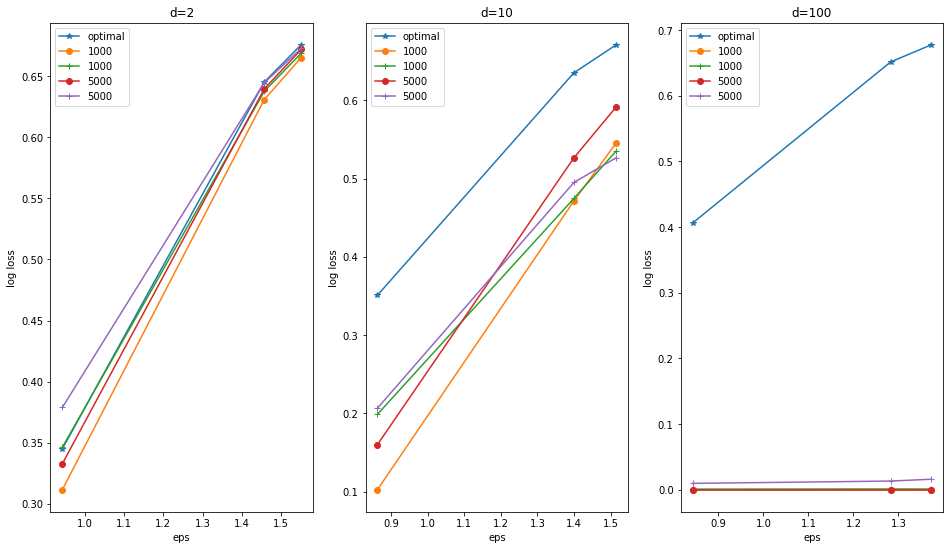

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(16, 9), gridspec_kw={'hspace':0.5})
for i in range(len(d_list)):
    row = int(i/3)
    col = int(i%3)
    axs[col].plot(x_list[i],plot_opt_log_loss_list[i],label='optimal', marker='*')
    for j in range(len(sample_num_list)):
        print(i,j)
        print(row,col)
        curr_label = str(sample_num_list[j])
        axs[col].plot(x_list[i],plot_emp_log_loss[i][j],label=curr_label, marker='o')
        axs[col].plot(x_list[i],plot_train_log_loss[i][j],label=curr_label, marker='+')
        axs[col].set(title='d='+str(d_list[i]),xlabel='eps',ylabel='log loss')
#     axs[row,col].plot(eps_opt_list[i],optimal_loss_list[i],label='optimal', linewidth=2, marker='o')
    axs[col].legend()

In [27]:
x_list

[[0.9430351125069351, 1.4567860238291532, 1.5506549330263055],
 [0.8629747219650739, 1.3995232801244584, 1.5152121914408772],
 [0.8426518066945282, 1.282588702030911, 1.3730430637442728]]

In [28]:
plot_opt_log_loss_list

[[0.34491639523934803, 0.6453204850392801, 0.6758949195686956],
 [0.3509940653880574, 0.6351600986326852, 0.6709956323402867],
 [0.40606415094051634, 0.6514627755112086, 0.6776215761232787]]

In [29]:
plot_emp_log_loss

[[[0.31148349390719, 0.6309778255987554, 0.6652485778552258],
  [0.3327080794632119, 0.6396285297846269, 0.6720884690245921]],
 [[0.10261372015020395, 0.47140841939463, 0.5455932580368453],
  [0.1601669880060015, 0.5264638959211501, 0.5916424420307279]],
 [[-0.0, -0.0, -0.0], [-0.0, -0.0, -0.0]]]

In [30]:
plot_train_log_loss

[[[0.34615088, 0.6377032, 0.66896516], [0.3787951, 0.6448023, 0.6728625]],
 [[0.19886252, 0.47464824, 0.53532153], [0.20664494, 0.49504596, 0.52661616]],
 [[0.00063691393, 0.0008676665, 0.00075983506],
  [0.009420172, 0.0129525205, 0.015761174]]]